In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm
%matplotlib inline

In [2]:
data = pd.read_csv('data/round.csv').drop('Unnamed: 0',axis=1)

In [3]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [4]:
data.shape

(249822, 12)

In [5]:
data.tail()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
249817,2016,340,26,608,40098,"Fitzpatrick, Matthew",4,10:20,71,T54,55.0,0.494344
249818,2016,340,26,608,46970,"Rahm, Jon",4,11:50,70,T23,27.0,0.240950
249819,2016,340,26,608,47287,"Tracy, Ethan",4,10:10,77,T65,65.5,0.589367
249820,2016,340,26,608,47959,"DeChambeau, Bryson",4,14:50,74,T15,16.0,0.141403
249821,2016,340,26,608,50490,"Parker, Chase",4,11:50,81,64,64.0,0.575792


In [6]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [7]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [8]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [9]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [10]:
print n_players,n_rounds,n_tournaments

2551 2754 612


In [11]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

In [12]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [13]:
def inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA,window_size=28):
    mat = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    for j in rounds_to_inflate:
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % j)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % j)!=0).astype(float)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
    if tournament_group>window_size:
        del inflate.__dict__[tournament_group-window_size]
    inflate.__dict__[tournament_group] = (mat,mat_1)
    out_mat = bmat([[inflate.__dict__[i][0][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    out_mat1 = bmat([[inflate.__dict__[i][1][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    return (out_mat,out_mat1)

In [14]:
def alpha(A,a):
    A.data[A.data<1e-6] = 0
    A.data[np.isnan(A.data)]=0
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [15]:
def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    mat.data[mat_1.data<1e-6] = 0
    mat_1.data[mat_1.data<1e-6] = 0
    mat.data[np.isnan(mat.data)] = 0
    mat_1.data[np.isnan(mat_1.data)] = 0
    
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    
    w_a[w_g<min_reps]=0
    solve.w_a = w_a
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [16]:
ranks,reps = [],[]
BETA = 6
a = .8
bin_size = 4
window_size = 28
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups=[set()]
tournaments = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA)
        if current_group==0:
            res = solve(A,G,a,1)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<=window_size else n_players:],solve.w_g[-n_players:])
            res = solve(A,G,a,1,w_a_approx,w_g_approx)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
    tournament_groups[current_group].add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    rounds_to_inflate.append(round_ind)

Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done
Tournament Group 22 done
Tournament Group 23 done
Tournament Group 24 done
Tournament Group 25 done
Tournament Group 26 done
Tournament Group 27 done
Tournament Group 28 done
Tournament Group 29 done
Tournament Group 30 done
Tournament Group 31 done
Tournament Group 32 done
Tournament Group 33 done
Tournament Group 34 done
Tournament Group 35 done
Tournament Group 36 done
Tournament Group 37 done
Tournament Group 38 done
Tournament Group 39 done
Tournament Group 40 done
Tournamen

In [23]:
tournament_groups[0:10]

[{'2003,1', '2003,2', '2003,3', '2003,4'},
 {'2003,5', '2003,6', '2003,7', '2003,8'},
 {'2003,10', '2003,11', '2003,12', '2003,9'},
 {'2003,13', '2003,14', '2003,16', '2003,18'},
 {'2003,19', '2003,20', '2003,21', '2003,22'},
 {'2003,23', '2003,24', '2003,25', '2003,26'},
 {'2003,27', '2003,28', '2003,29', '2003,30'},
 {'2003,32', '2003,33', '2003,34', '2003,35'},
 {'2003,37', '2003,41', '2003,45', '2003,47'},
 {'2003,100', '2003,472', '2003,54', '2003,60'}]

In [17]:
master_df = pd.DataFrame({'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Field_Strength':[],
                          'Finishing_Pct':[],'Rating':[],'Reps':[],'Pct_Reps':[]})
for j in range(len(ranks)):
    df = pd.DataFrame({'player_ind':range(n_players),
                       'rank':ranks[j],
                       'reps':reps[j]}).dropna()
    pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'pct_reps'] = pct_reps
    rank_dict,reps_dict,pct_reps_dict = df['rank'].to_dict(),df['reps'].to_dict(),df['pct_reps'].to_dict()
    years = [int(i.split(',')[0]) for i in tournament_groups[j+1]]
    t_ids = [int(i.split(',')[1]) for i in tournament_groups[j+1]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    df3['Rating'] = df3['Player_Index'].map(rank_dict)
    df3['Reps'] = df3['Player_Index'].map(reps_dict)
    df3['Pct_Reps'] = df3['Player_Index'].map(pct_reps_dict)
    df3 = df3[df3.Rating!=0].dropna()
    tourn_strength_dict = df3.groupby('Permanent_Tournament_#')['Rating'].mean().to_dict()
    df3['Field_Strength'] = df3['Permanent_Tournament_#'].map(tourn_strength_dict)
    master_df = pd.concat([master_df,df3])

# master_df = master_df.dropna()
# master_df = master_df[master_df.Rating!=0]

In [18]:
master_df.head(5)

,Course_#,Field_Strength,Finishing_Pct,Pct_Reps,Permanent_Tournament_#,Player_Index,Rating,Reps
0,500,1.005171,0.116898,0.216867,7,0,1.016548,1492.599935
1,6,1.003548,0.114773,0.891566,6,1,1.023718,5301.597327
2,500,1.005171,0.116898,0.891566,7,1,1.023718,5301.597327
3,6,1.003548,0.730682,0.467871,6,2,1.009786,2815.719184
4,500,1.005171,0.075231,0.467871,7,2,1.009786,2815.719184


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

ols = LinearRegression()

In [20]:
np.corrcoef(master_df.Rating,master_df.Finishing_Pct)

array([[ 1.        , -0.32107415],
       [-0.32107415,  1.        ]])

In [21]:
len(master_df)

94064

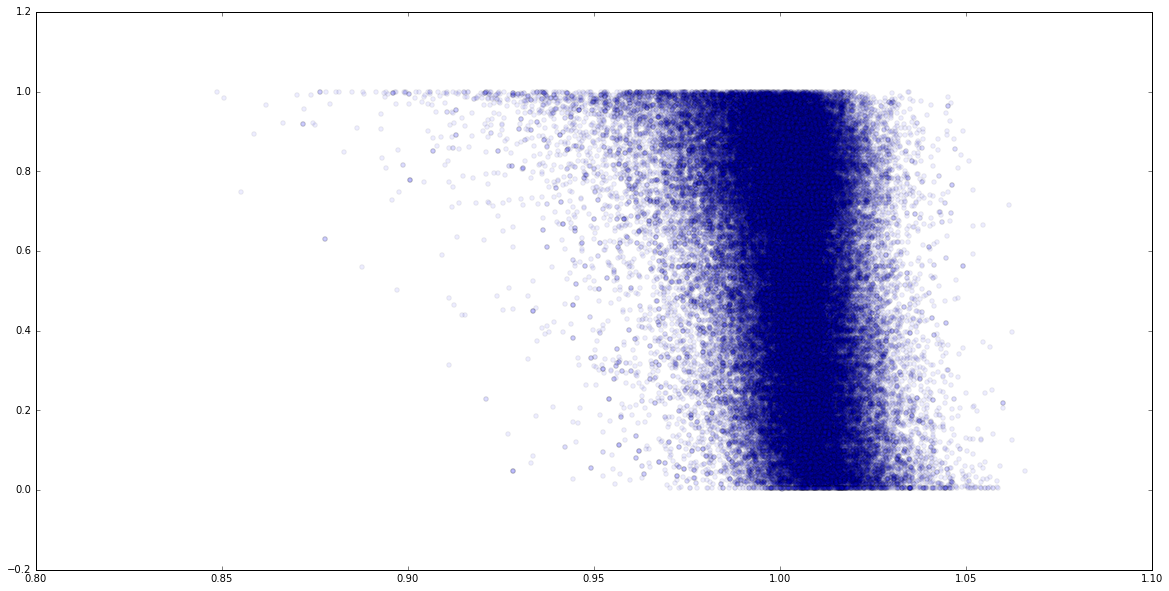

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(master_df.Rating,master_df.Finishing_Pct,alpha=.07);

In [36]:
X,y = master_df.Rating.values-master_df.Field_Strength.values,master_df.Finishing_Pct.values

In [32]:
ols.fit(X[:,None],y)
print ols.intercept_,ols.coef_[0]

0.560934422354 -6.85544834547


In [97]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
print ols.intercept_,ols.coef_[0]

0.562650594049 -8.81628516904


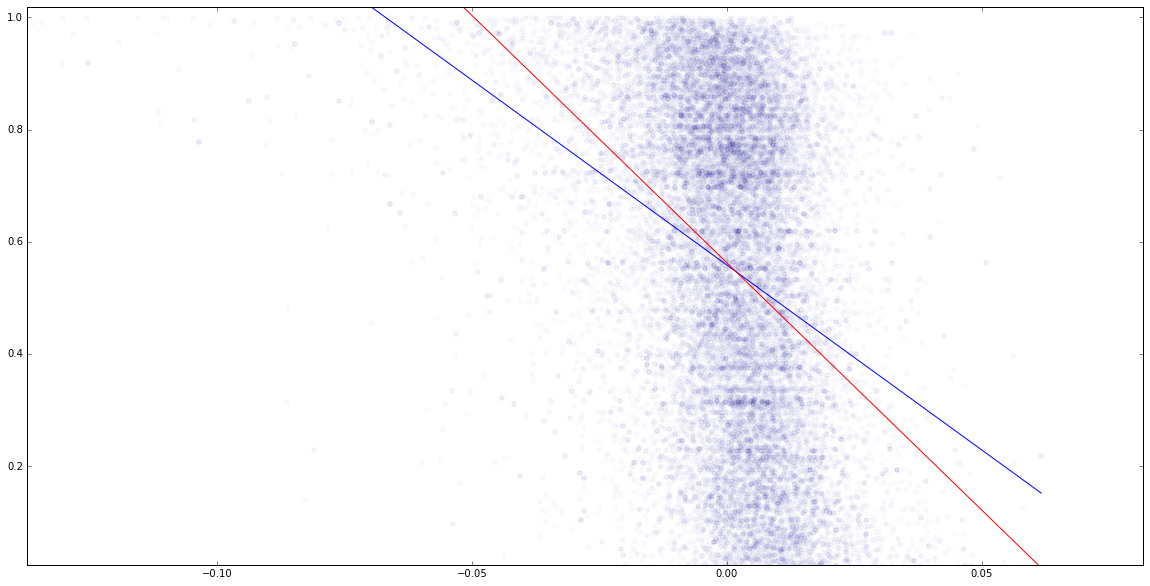

In [98]:
ols.fit(X[:,None],y)
predictions_u = ols.predict(np.sort(X)[:,None])
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(X,y,alpha=.02)
plt.plot(np.sort(X),predictions_u,c='b')
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
predictions_w = ols.predict(np.sort(X)[:,None])
plt.plot(np.sort(X),predictions_w,c='r')
plt.xlim(X.min()+.02,X.max()+.02);
plt.ylim(y.min()+.02,y.max()+.02);

In [26]:
ols.fit(X[:,None],y,sample_weight=master_df.Reps)
residuals = ols.predict(X[:,None]) - y
np.corrcoef(residuals,master_df.Reps)

array([[ 1.        , -0.01667141],
       [-0.01667141,  1.        ]])

In [90]:
squared_residuals = (ols.predict(X[:,None]) - y)**2
weighted_squared_residuals = squared_residuals * master_df.Reps.values / master_df.Reps.sum()
RMWSR = np.mean(weighted_squared_residuals)**.5

In [93]:
RMWSR

0.0021116823889155006

In [100]:
kfold = KFold(len(y),n_folds=10,shuffle=True)
scores = []
for train,test in kfold:
    ols.fit(X[train,None],y[train],sample_weight=master_df.Reps.values[train])
    predictions = ols.predict(X[test,None])
    squared_residuals = (predictions - y[test])**2
    weighted_squared_residuals = squared_residuals * master_df.Reps.values[test] / master_df.Reps.values[test].sum()
    RMWSR = np.mean(weighted_squared_residuals)**.5
    scores.append(RMWSR)
print np.mean(scores),np.std(scores),np.mean(scores)+np.std(scores)/10**.5

0.00667804590585 9.66755461517e-05 0.00670861739784


In [33]:
y = (ols.predict(X[:,None]) - y)**2
X = master_df.Reps.values

In [37]:
X = sm.add_constant(X)

In [34]:
ols.fit(X[:,None],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
w = ols.predict(X[:,None])

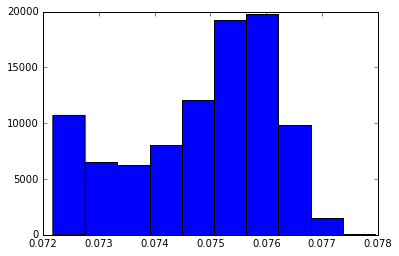

In [38]:
plt.hist(w);

In [39]:
pd.Series(master_df.Field_Strength).describe()

count    94064.000000
mean         1.002345
std          0.004796
min          0.987007
25%          0.999344
50%          1.001648
75%          1.005182
max          1.024925
Name: Field_Strength, dtype: float64

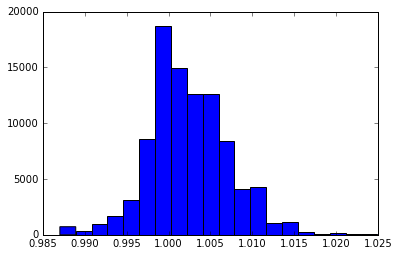

In [40]:
plt.hist(master_df.Field_Strength.values,20);

In [41]:
model = sm.WLS(y, X, 1/w)
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            WLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Sun, 04 Sep 2016   Prob (F-statistic):               0.00
Time:                        19:17:45   Log-Likelihood:                -11538.
No. Observations:               94064   AIC:                         2.308e+04
Df Residuals:                   94062   BIC:                         2.310e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5611      0.001    629.102      0.0

In [89]:
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)

In [52]:
cross_val_score(ols,X,y,cv=10).mean()

NameError: name 'cross_val_score' is not defined

In [135]:
X.shape

(13645, 3)

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


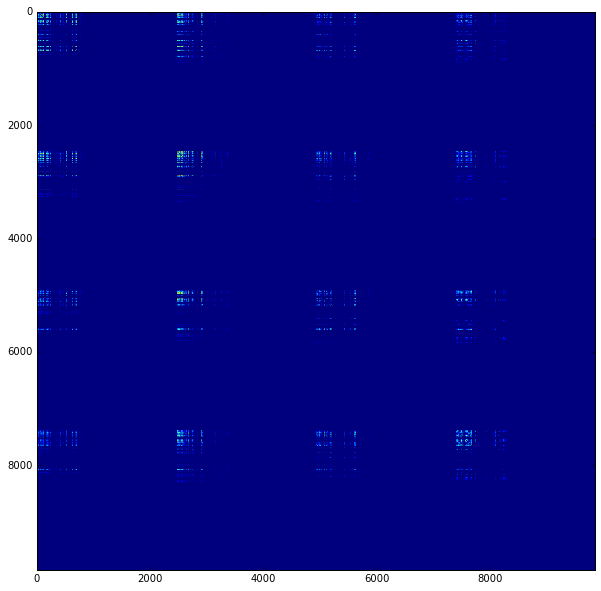

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [158]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[15]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.041156
277,277,"Woods, Tiger",1.040426
12,12,"Els, Ernie",1.036093
341,341,"Harrington, Padraig",1.035531
572,572,"Ho, S.K.",1.035140
180,180,"Weir, Mike",1.031608
532,532,"Ruiz, Marco",1.029694
162,162,"Mickelson, Phil",1.029583
27,27,"Goosen, Retief",1.029180
331,331,"Scott, Adam",1.028445


In [47]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [48]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [76]:
inds_to_plot = [names_to_ind['Mickelson, Phil'],names_to_ind['Woods, Tiger'],
                names_to_ind['S, Vijay'],names_to_ind['Donald, Luke']]

#names_to_ind['Woods, Tiger'],names_to_ind['Day, Jason'],names_to_ind['Donald, Luke']
#names_to_ind['Stricker, Steve'],names_to_ind['Spieth, Jordan'],

In [77]:
from numpy import trapz

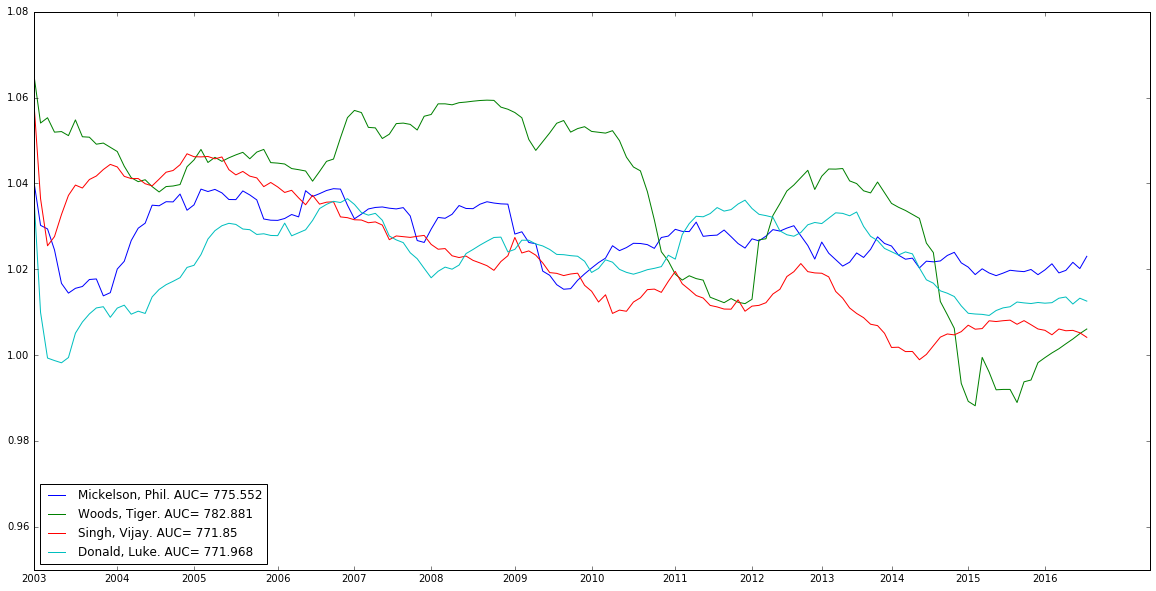

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    y = np.array([ranks[i][j] for i in range(len(ranks))])
    y = y[np.logical_not(np.isnan(y))]
    area = trapz(y, dx=5)
    plt.plot([ranks[i][j] for i in range(len(ranks))],label = inds_to_name[j]+'. AUC= %g' % area);
plt.legend(loc=3);
plt.xticks([i[1] for i in year_inds], [i[0] for i in year_inds]);
plt.ylim(.95,1.08);

In [42]:
year_inds = [max([map(int,[i.split(',')[0] for i in j])]) for j in tournament_groups]

In [43]:
from collections import Counter
year_inds = [Counter(i) for i in year_inds]

In [44]:
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]

In [45]:
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]